In [1]:
import torch
from torch.utils.data import Dataset
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import h5py

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as alb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:

class YNet(nn.Module):
    def __init__(self):
        super(YNet, self).__init__()
        
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
               # nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        # Encoder for input image
        self.input_conv0 = CBR(1, 32)
        self.input_conv1 = CBR(32, 64)
        self.input_conv2 = CBR(64, 64)
        self.input_pool1 = nn.MaxPool2d(2, 2)
        self.input_conv3 = CBR(64, 128)
        self.input_conv4 = CBR(128, 128)
        self.input_pool2 = nn.MaxPool2d(2, 2)
        
        # Encoder for reference image
        self.ref_conv0 = CBR(1, 32)
        self.ref_conv1 = CBR(32, 64)
        self.ref_conv2 = CBR(64, 64)
        self.ref_pool1 = nn.MaxPool2d(2, 2)
        self.ref_conv3 = CBR(64, 128)
        self.ref_conv4 = CBR(128, 128)
        self.ref_pool2 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck_conv1 = CBR(256, 256)
        self.bottleneck_conv2 = CBR(256, 256)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder_conv1 = CBR(256, 128)
        self.decoder_conv2 = CBR(128, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder_conv3 = CBR(128, 64)
        self.decoder_conv4 = CBR(64, 32)
        self.output_conv = nn.Conv2d(32, 1, 1)
        
    def forward(self, input_img, ref_img):
        # Encode input image
        enc1_input = self.input_conv0(input_img)
        enc2_input = self.input_conv1(enc1_input)
        enc2_input = self.input_conv2(enc2_input)
        enc3_input = self.input_pool1(enc2_input)
        enc3_input = self.input_conv3(enc3_input)
        enc3_input = self.input_conv4(enc3_input)
        enc4_input = self.input_pool2(enc3_input)
        
        # Encode reference image
        enc1_ref = self.ref_conv0(ref_img)
        enc2_ref = self.ref_conv1(enc1_ref)
        enc2_ref = self.ref_conv2(enc2_ref)
        enc3_ref = self.ref_pool1(enc2_ref)
        enc3_ref = self.ref_conv3(enc3_ref)
        enc3_ref = self.ref_conv4(enc3_ref)
        enc4_ref = self.ref_pool2(enc3_ref)
        
        # Concatenate features at the bottleneck
        bottleneck_input = torch.cat((enc4_input, enc4_ref), dim=1)
        bottleneck_output = self.bottleneck_conv1(bottleneck_input)
        bottleneck_output = self.bottleneck_conv2(bottleneck_output)
        
        # Decoder
        dec1 = self.upconv1(bottleneck_output)
        dec1 = torch.cat((dec1, enc3_input), dim=1)
        dec1 = self.decoder_conv1(dec1)
        dec1 = self.decoder_conv2(dec1)
        
        dec2 = self.upconv2(dec1)
        dec2 = torch.cat((dec2, enc2_input), dim=1)
        dec2 = self.decoder_conv3(dec2)
        dec2 = self.decoder_conv4(dec2)
        
        output = self.output_conv(dec2)
        return output

# Instantiate the model
model = YNet()
#print(model)

In [3]:
state_dict = torch.load("best_model.pt")
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

YNet(
  (input_conv0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (input_conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (input_conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (input_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (input_conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (input_conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (input_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ref_conv0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)

In [4]:
IMAGE_SIZE_X, IMAGE_SIZE_Y = 140, 200

def get_augs():
    return alb.Compose([
      alb.Resize(IMAGE_SIZE_X, IMAGE_SIZE_Y)
      ], is_check_shapes=False)

def get_val_augs():
    return alb.Compose([
      alb.Resize(IMAGE_SIZE_X, IMAGE_SIZE_Y),
      ], is_check_shapes=False)


def model_pred(model, img, ref, plot=False):
    #device = 'cuda'
    img = (img / np.max(img)).astype(np.float32)
    ref = (ref / np.max(ref)).astype(np.float32)
    kernel_size = 5
    img = cv2.medianBlur(img, kernel_size)
    ref = cv2.medianBlur(ref, kernel_size)
    
    M, N = (np.array(img.shape) // 5)
    img = cv2.resize(img, (N, M))
    ref = cv2.resize(ref, (N, M))
    
    data = get_augs()(image = img)
    img = data['image']
    
    data = get_augs()(image = ref)
    ref = data['image']
    
    img = np.expand_dims(img, axis=0)
    ref = np.expand_dims(ref, axis=0)
    
    testX = torch.tensor(img).to(device)
    test_ref = torch.tensor(ref).to(device)
    
    model.eval()
    with torch.no_grad():
        test_pred = model(testX.unsqueeze(0), test_ref.unsqueeze(0))

    testX = testX.squeeze().cpu()
    test_pred = test_pred.squeeze().cpu()
    
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].imshow(testX)
        ax[0].set_title("Input")
        ax[1].imshow(test_pred)
        ax[1].set_title("Model Prediction")
    
    return testX, test_pred


def load_preprocess_data(filestr, image_idx, ref_img, row_limits=(None, None), col_limits=(None, None)):
    with h5py.File(filestr, 'r') as fi:
        imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][image_idx][row_limits[0]:row_limits[1], col_limits[0]:col_limits[1]])
    
    pred_in, pred_out = model_pred(model, imarr, ref_img)
    return pred_in, pred_out


def get_energy_loss(pred_in, pred_out, dE=0.194, dT=3.876):
    pixel_values = np.tile(np.arange(pred_in.shape[0]), (pred_in.shape[1], 1)).T
    mean_value = np.array(torch.mean(pred_in, dim=0))
    
    mean_px_sase_on = np.ma.average(pixel_values, weights=pred_in, axis=0)
    mean_px_sase_on[mean_value < 0.005] = None
    mean_px_sase_off = np.ma.average(pixel_values, weights=pred_out, axis=0)
    mean_px_sase_off[mean_value < 0.005] = None
    mean_diff = mean_px_sase_on - mean_px_sase_off
    
    std_px_sase_on = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_on) ** 2, weights=pred_in, axis=0))
    std_px_sase_off = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_off) ** 2, weights=pred_out, axis=0))
    std_diff = std_px_sase_on ** 2 - std_px_sase_off ** 2
    
    power_px = np.clip(mean_diff.copy(), a_min=0, a_max=None)
    power_px[np.isnan(power_px)] = 0
    power = power_px * dE
    
    return power, mean_px_sase_off, mean_px_sase_on


def get_power_profile(filestr, image_idx, ref_img, dE=0.194, dT=3.876, row_limits=(None, None), col_limits=(None, None)):
    pred_in, pred_out = load_preprocess_data(filestr, image_idx, ref_img, row_limits, col_limits)
    energy_loss, sase_off, sase_on = get_energy_loss(pred_in, pred_out, dE, dT)
    T = np.linspace(0, len(energy_loss), len(energy_loss)) * dT

    with h5py.File(filestr, 'r') as fi:
        gmdarr = np.array(fi['/FL2/Photon Diagnostic/GMD/Pulse resolved energy/energy tunnel/value'])[:, 0]
        bunch_charge = np.array(fi['/FL1/Electron Diagnostic/Bunch charge/at gun/value'])
    
    q = sorted(bunch_charge[0])[-1] * 1e-9
    q_px = float(q / torch.sum(pred_in))
    
    curr_profile = (np.sum(np.array(pred_in), axis=0) * q_px) / dT / 1e-15
    power = 1e6 * energy_loss * curr_profile
    pulse_energy = np.trapz(power, T * 1e-15) * 1e6  # pulse energy in microjoules
    pulse_energy_gmd = gmdarr[image_idx][0]
    
    return power, pulse_energy, pulse_energy_gmd


def plot_results(filestr, image_idx, ref_img, dE=0.194, dT=3.876, row_limits=(None, None), col_limits=(None, None)):
    pred_in, pred_out = load_preprocess_data(filestr, image_idx, ref_img, row_limits, col_limits)
    energy_loss, sase_off, sase_on = get_energy_loss(pred_in, pred_out, dE, dT)
    T = np.linspace(0, len(energy_loss), len(energy_loss)) * dT
    
    power, E, E_gmd = get_power_profile(filestr, image_idx, ref_img, dE, dT, row_limits, col_limits)

    fig = plt.figure(figsize=(15, 8))
    gs_main = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    ax1 = fig.add_subplot(gs_main[0, 0])
    ax1.imshow(pred_in, aspect='auto')
    ax1.set_title('Input SASE-ON')

    ax2 = fig.add_subplot(gs_main[0, 1])
    ax2.imshow(pred_out, aspect='auto')
    ax2.set_title('Predicted SASE-OFF')
    
    gs_lower_left = gs_main[1, 0].subgridspec(2, 1, height_ratios=[4, 1])
    
    ax3 = fig.add_subplot(gs_lower_left[0])
    ax3.imshow(pred_in, cmap='turbo', aspect='auto')
    ax3.plot(sase_on, 'red', alpha=0.8)
    ax3.plot(sase_off, 'orange', alpha=0.8)
    ax3.set_xticklabels([])
    
    ax4 = fig.add_subplot(gs_lower_left[1])
    ax4.plot(T, energy_loss, label="power profile from mean")
    ax4.set_xlim(min(T), max(T))
    ax4.set_xlabel("t (fs)")
    ax4.set_ylabel("dE (MeV)")
    
    ax5 = fig.add_subplot(gs_main[1, 1])
    ax5.plot(T, power / 1e9, 'r')
    ax5.set_xlim(min(T), max(T))
    ax5.set_xlabel("t (fs)")
    ax5.set_ylabel("power (GW)")

    pulse_energy_text = f"Integrated Power: {E:.2f} μJ \nPulse Energy from GMD: {E_gmd:.2f} μJ"
    ax = plt.gca()
    ax.text(0.95, 0.95, pulse_energy_text, transform=ax.transAxes, ha='right', va='top')
    
    plt.suptitle(f"{os.path.basename(filestr)}   index: {image_idx}")
    plt.show()


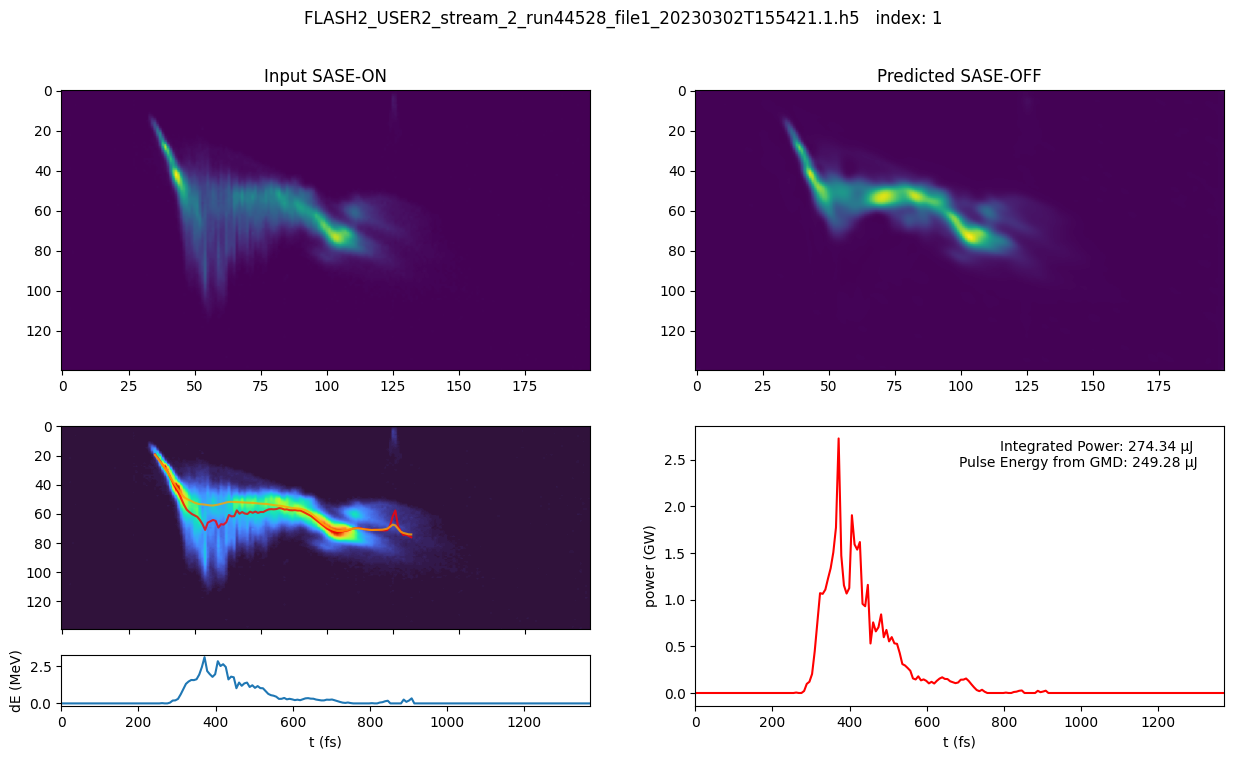

In [10]:
filepath = '/asap3/flash/gpfs/fl21/2023/data/11016859/raw/hdf/express-3/fl2user2'
filestr = glob.glob(filepath+f'/*run{44525}*20230302*')[18]

with h5py.File(filestr,'r') as fi:
        ref_img = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][1][600:1200,200:1800])
        
filepath = '/asap3/flash/gpfs/fl21/2023/data/11016859/raw/hdf/express-3/fl2user2'
filestr = glob.glob(filepath+f'/*run{44528}*20230302*')[0]

dE = 600 * 0.042 / IMAGE_SIZE_X  # MeV/pixel
dT = 2360 * 0.58 / IMAGE_SIZE_Y  # fs/pixel

image_idx = 1

row_limits=(600, 1200); col_limits=(None, None) #(600, 2000)

plot_results(filestr, image_idx, ref_img, dE, dT, row_limits, col_limits)

In [7]:
run_number = 44527
filepath = '/asap3/flash/gpfs/fl21/2023/data/11016859/raw/hdf/express-3/fl2user2'
filestr = glob.glob(filepath+f'/*run{run_number}*20230302*')[2]

dE = 600 * 0.042 / IMAGE_SIZE_X  # MeV/pixel
dT = 2360 * 0.58 / IMAGE_SIZE_Y  # fs/pixel


with h5py.File(filestr,'r') as fi:
    imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'])
img_len = imarr.shape[0]

E0_list = []
Egmd_list = []
for image_idx in tqdm(range(img_len)):
    try:
        _, E0, E_gmd = get_power_profile(filestr, image_idx, ref_img, dE, dT, row_limits) #, col_limits)
    except IndexError:
        break
    E0_list.append(E0)
    Egmd_list.append(E_gmd)


100%|██████████| 569/569 [00:44<00:00, 12.86it/s]


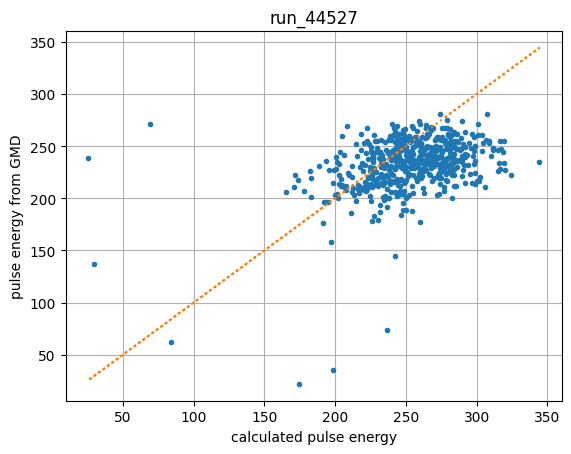

In [8]:
plt.plot(E0_list, Egmd_list, '.')
plt.xlabel("calculated pulse energy")
plt.ylabel("pulse energy from GMD")
plt.plot(E0_list, E0_list, ':')
plt.title(f"run_{run_number}")
plt.grid()

100%|██████████| 581/581 [00:44<00:00, 12.92it/s]


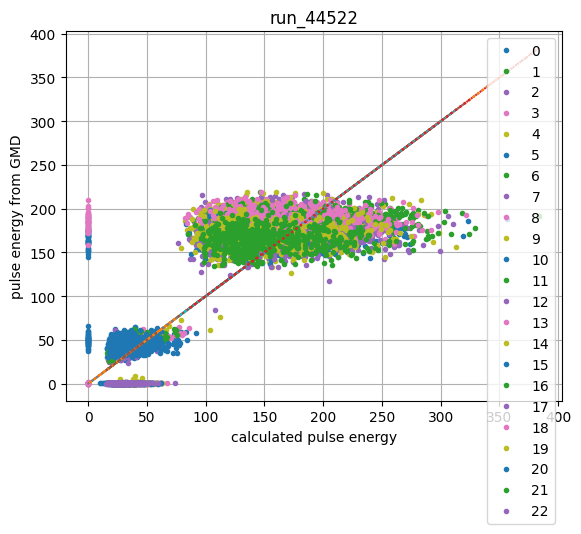

In [15]:
run_number = 44527
filepath = '/asap3/flash/gpfs/fl21/2023/data/11016859/raw/hdf/express-3/fl2user2'
filestr = glob.glob(filepath+f'/*run{run_number}*20230302*')[:]

dE = 600 * 0.042 / IMAGE_SIZE_X  # MeV/pixel
dT = 2360 * 0.58 / IMAGE_SIZE_Y  # fs/pixel

E0_all = []
Egmd_all = []

for i, file in enumerate(filestr):
    with h5py.File(file,'r') as fi:
        imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'])
    img_len = imarr.shape[0]

    E0_list = []
    Egmd_list = []
    for image_idx in tqdm(range(img_len)):
        try:
            _, E0, E_gmd = get_power_profile(file, image_idx, ref_img, dE, dT, row_limits) #, col_limits)
        except IndexError:
            break
        E0_list.append(E0)
        Egmd_list.append(E_gmd)
    
    E0_all.append(E0_list)
    Egmd_all.append(Egmd_list)
    
    plt.plot(E0_list, Egmd_list, '.', label=f"{i}")
    plt.plot(E0_list, E0_list, ':')
    
plt.xlabel("calculated pulse energy")
plt.ylabel("pulse energy from GMD")
plt.title(f"run_{run_number}")
plt.legend()
plt.grid()

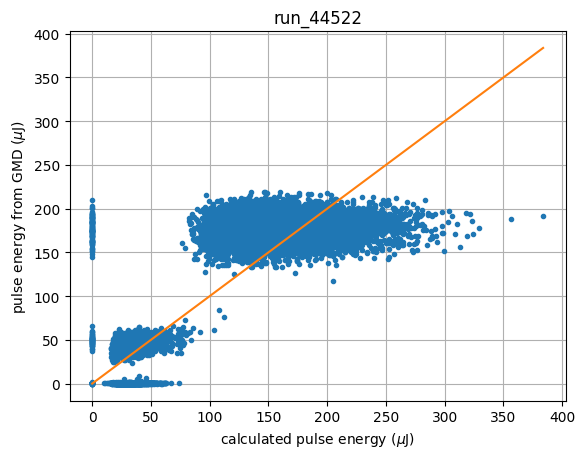

In [16]:
Egmd_l = [item for sublist in Egmd_all for item in sublist]
E0_l = [item for sublist in E0_all for item in sublist]

plt.plot(E0_l, Egmd_l, '.')
plt.plot([min(E0_l), max(E0_l)], [min(E0_l), max(E0_l)])

plt.xlabel("calculated pulse energy ($\mu$J)")
plt.ylabel("pulse energy from GMD ($\mu$J)")
plt.title(f"run_{run_number}")
plt.grid()

pulse_E = np.array([E0_l, Egmd_l])
np.save(f"pulse_energy_run_{run_number}.npy", pulse_E)

In [36]:
Egmd_l_44526 = Egmd_l
E0_l_44526 = E0_l

In [30]:
pulse_E = np.load("pulse_energy_run_44527.npy")

Text(0, 0.5, 'pulse energy from GMD ($\\mu$J)')

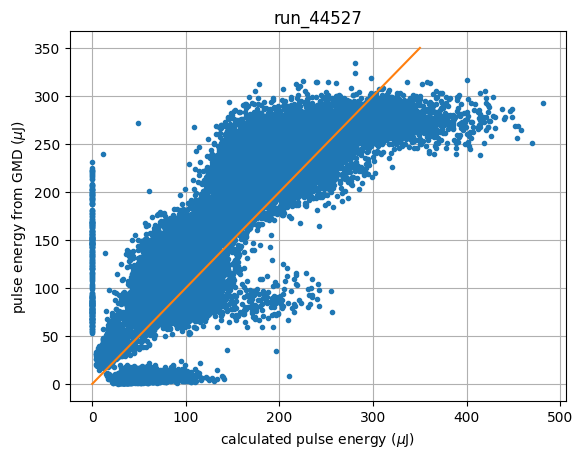

In [40]:
plt.plot(pulse_E[0], pulse_E[1],'.')
plt.plot([0,350], [0, 350])
plt.grid()
plt.title("run_44527")
plt.xlabel("calculated pulse energy ($\mu$J)")
plt.ylabel("pulse energy from GMD ($\mu$J)")

In [ ]:
def model_pred(model, img, plot=False):
    #device = 'cuda'
    img = (img / np.max(img)).astype(np.float32)
    kernel_size = 5
    img = cv2.medianBlur(img, kernel_size)
    M, N = (np.array(img.shape) // 5)
    img = cv2.resize(img, (N, M))
    data = get_augs()(image = img)
    img = data['image']
    
    img = np.expand_dims(img, axis=0)
    testX = torch.tensor(img).to(device)
    
    model.eval()
    with torch.no_grad():
        test_pred = model(testX.unsqueeze(0))

    testX = testX.squeeze().cpu()
    test_pred = test_pred.squeeze().cpu()
    
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].imshow(testX)
        ax[0].set_title("Input")
        ax[1].imshow(test_pred)
        ax[1].set_title("Model Prediction")
    
    return testX, test_pred


def plot_power_profile(pred_in, pred_out, dE=0.194, dT=3.876):
    
    pixel_values = np.tile(np.arange(pred_in.shape[0]), (pred_in.shape[1],1)).T
    mean_value = np.array(torch.mean(pred_in, dim=0))
    
    mean_px_sase_on  = np.ma.average(pixel_values, weights=pred_in, axis=0)
    mean_px_sase_on[mean_value < 0.005] = None
    mean_px_sase_off = np.ma.average(pixel_values, weights=pred_out, axis=0)
    mean_px_sase_off[mean_value < 0.005] = None
    mean_diff = mean_px_sase_on - mean_px_sase_off
    
    std_px_sase_on = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_on) ** 2, weights=pred_in, axis=0))
    std_px_sase_off = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_off) ** 2, weights=pred_out, axis=0))
    std_diff = std_px_sase_on**2 - std_px_sase_off**2
    
    power_px = mean_diff.copy()
    power_px[np.isnan(power_px)] = 0
    power_px = np.clip(power_px, a_min=0, a_max=None)
    power = power_px * dE
    
    T = np.linspace(0, len(power_px), len(power_px)) * dT
    E = np.linspace(0, pred_in.shape[0], pred_in.shape[0]) * dE
    E -= np.mean(E)
    
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]})#, sharex=True)

    #ax[0].contourf(T, E, np.flip(np.array(pred_in), axis=0), 100)
    ax[0].imshow(pred_in, cmap='turbo', aspect='auto')
    ax[0].plot(mean_px_sase_on , alpha=0.5)
    ax[0].plot(mean_px_sase_off, alpha=0.5)
    ax[0].set_xticklabels([])  # Hide x tick labels

    ax[1].plot(T, power, label = "power profile from mean") #, alpha=0.8)
    ax[1].set_xlim(min(T), max(T))
    ax[1].set_xlabel("t (fs)")
    ax[1].set_ylabel("dE (MeV)")
    #plt.plot(140 - std_diff* 5**(2/3) * 0.15, label = "power profile from energy spread", alpha=0.7)
    #plt.legend()
    
    return np.array(power)

In [ ]:
def get_energy_loss(pred_in, pred_out, dE=0.194, dT=3.876):
    
    pixel_values = np.tile(np.arange(pred_in.shape[0]), (pred_in.shape[1],1)).T
    mean_value = np.array(torch.mean(pred_in, dim=0))
    
    mean_px_sase_on  = np.ma.average(pixel_values, weights=pred_in, axis=0)
    mean_px_sase_on[mean_value < 0.005] = None
    mean_px_sase_off = np.ma.average(pixel_values, weights=pred_out, axis=0)
    mean_px_sase_off[mean_value < 0.005] = None
    mean_diff = mean_px_sase_on - mean_px_sase_off
    
    std_px_sase_on = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_on) ** 2, weights=pred_in, axis=0))
    std_px_sase_off = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_off) ** 2, weights=pred_out, axis=0))
    std_diff = std_px_sase_on**2 - std_px_sase_off**2
    
    power_px = mean_diff.copy()
    power_px[np.isnan(power_px)] = 0
    power_px = np.clip(power_px, a_min=0, a_max=None)
    power = power_px * dE
    
    return power, mean_px_sase_off, mean_px_sase_on

def get_power_profile(filestr, image_idx, dE=0.194, dT=3.876, row_cut=None):
    
    with h5py.File(filestr,'r') as fi:
        imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][image_idx][600:1200,200:1800])
    
    pred_in, pred_out = model_pred(model, imarr[row_cut:,:])
    
    energy_loss, sase_off, sase_on = get_energy_loss(pred_in, pred_out, dE, dT)
    T = np.linspace(0, len(energy_loss), len(energy_loss)) * dT
    
    with h5py.File(filestr,'r') as fi:
        gmdarr = np.array(fi['/FL2/Photon Diagnostic/GMD/Pulse resolved energy/energy tunnel/value'])[:,0]
        bunch_charge = np.array(fi['/FL1/Electron Diagnostic/Bunch charge/at gun/value'])

    q = sorted(bunch_charge[0])[-1] * 1e-9
    #q = bunch_charge[image_idx][251] * 1e-9
    q_px = float(q / torch.sum(pred_in))

    curr_profile = (np.sum(np.array(pred_in), axis=0) * q_px)/ dT/1e-15
    power = 1e6 * energy_loss * curr_profile         
    pulse_energy = np.trapz(power, T*1e-15) * 1e6    # pulse energy in microjoules
    pulse_energy_gmd = gmdarr[image_idx][0]
    
    return power, pulse_energy, pulse_energy_gmd

def get_power_profile_npy(pred_in, pred_out, dE=0.194, dT=3.876, charge=0.3e-9):
    
    energy_loss, sase_off, sase_on = get_energy_loss(pred_in, pred_out, dE, dT)
    T = np.linspace(0, len(energy_loss), len(energy_loss)) * dT
    
    q_px = float(charge / torch.sum(pred_in))
    curr_profile = (np.sum(np.array(pred_in), axis=0) * q_px)/ dT/1e-15
    
    power = 1e6 * energy_loss * curr_profile  
    pulse_energy = np.trapz(power, T*1e-15) * 1e6  # pulse energy in microjoules
    #pulse_energy_gmd = gmdarr[image_idx][0]
    
    return power, pulse_energy #, pulse_energy_gmd
    

In [ ]:
def plot_results(filestr, image_idx, dE=0.194, dT=3.876, row_cut=None):
    
    with h5py.File(filestr,'r') as fi:
        imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][image_idx][600:1200,200:1800])
    
    pred_in, pred_out = model_pred(model, imarr[row_cut:,:])
                                   
    energy_loss, sase_off, sase_on = get_energy_loss(pred_in, pred_out, dE, dT)
    
    T = np.linspace(0, len(energy_loss), len(energy_loss)) * dT
    
    power, E, E_gmd = get_power_profile(filestr, image_idx, dE, dT, row_cut)
    #print(E, E_gmd)
    
    fig = plt.figure(figsize=(15,8))
    gs_main = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    ax1 = fig.add_subplot(gs_main[0, 0])
    ax1.imshow(pred_in, aspect='auto')
    ax1.set_title('Input SASE-ON')

    ax2 = fig.add_subplot(gs_main[0, 1])
    ax2.imshow(pred_out, aspect='auto')
    ax2.set_title('Predicted SASE-OFF')
    
    gs_lower_left = gs_main[1, 0].subgridspec(2, 1, height_ratios=[4, 1])
    
    ax3 = fig.add_subplot(gs_lower_left[0])
    ax3.imshow(pred_in, cmap='turbo', aspect='auto')
    ax3.plot(sase_on , 'red', alpha=0.8)
    ax3.plot(sase_off, 'orange', alpha=0.8)
    ax3.set_xticklabels([])
    
    ax4 = fig.add_subplot(gs_lower_left[1])
    ax4.plot(T, energy_loss, label = "power profile from mean") #, alpha=0.8)
    ax4.set_xlim(min(T), max(T))
    ax4.set_xlabel("t (fs)")
    ax4.set_ylabel("dE (MeV)")
    
    ax5 = fig.add_subplot(gs_main[1, 1])
    ax5.plot(T, power/1e9, 'r')
    ax5.set_xlim(min(T), max(T))
    ax5.set_xlabel("t (fs)")
    ax5.set_ylabel("power (GW)")

    pulse_energy_text = f"Integrated Power: {E:.2f}" + " $\mu$J \n" + f"Pulse Energy from GMD: {E_gmd:.2f} " + " $\mu$J"

    ax = plt.gca()
    ax.text(0.95, 0.95, pulse_energy_text , transform=ax.transAxes, ha='right', va='top')
    
    plt.suptitle(f"{os.path.basename(filestr)}   index: {image_idx}")
    

def plot_results_npy(pred_in, pred_out, E_gmd, dE=0.194, dT=3.876):
    
    energy_loss, sase_off, sase_on = get_energy_loss(pred_in, pred_out, dE, dT)
    power, pul_E = get_power_profile_npy(pred_in, pred_out, dE, dT)
    
    T = np.linspace(0, len(energy_loss), len(energy_loss)) * dT
    
    fig = plt.figure(figsize=(15,8))
    gs_main = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    ax1 = fig.add_subplot(gs_main[0, 0])
    ax1.imshow(pred_in, aspect='auto')
    ax1.set_title('Input SASE-ON')

    ax2 = fig.add_subplot(gs_main[0, 1])
    ax2.imshow(pred_out, aspect='auto')
    ax2.set_title('Predicted SASE-OFF')
    
    gs_lower_left = gs_main[1, 0].subgridspec(2, 1, height_ratios=[4, 1])
    
    ax3 = fig.add_subplot(gs_lower_left[0])
    ax3.imshow(pred_in, cmap='turbo', aspect='auto')
    ax3.plot(sase_on , 'red', alpha=0.8)
    ax3.plot(sase_off, 'orange', alpha=0.8)
    ax3.set_xticklabels([])
    
    
    ax4 = fig.add_subplot(gs_lower_left[1])
    ax4.plot(T, energy_loss, label = "power profile from mean") #, alpha=0.8)
    ax4.set_xlim(min(T), max(T))
    ax4.set_xlabel("t (fs)")
    ax4.set_ylabel("dE (MeV)")
    
    ax5 = fig.add_subplot(gs_main[1, 1])
    ax5.plot(T, power/1e9, 'r')
    ax5.set_xlim(min(T), max(T))
    ax5.set_xlabel("t (fs)")
    ax5.set_ylabel("power (GW)")

    pulse_energy_text = f"Integrated Power: {pul_E:.2f}" + " $\mu$J \n" + f"Pulse Energy from GMD: {E_gmd:.2f} " + " $\mu$J"

    ax = plt.gca()
    ax.text(0.95, 0.95, pulse_energy_text , transform=ax.transAxes, ha='right', va='top')
    